<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
## openEO Platform UC6 - Near Real Time Forest Dynamics
### Author michele.claus@eurac.edu
### Date: 2021/09/10

In [ ]:
from eo_utils import *

## Connect to openEO

In [ ]:
backend = "https://openeo.cloud"
conn = openeo.connect(backend)

### Authenticate

In [ ]:
conn = conn.authenticate_oidc(provider_id="egi")

### Select the area of interest from the map using the rectangle tool. The selected area will be the one where you want to look for changes.

In [ ]:
center = [46.35, 11.45]
zoom = 12
eoMap = openeoMap(center,zoom)
eoMap.map

In [ ]:
bbox = eoMap.getBbox()
print("Coordinates selected from map:",'\n west',bbox[0],'\n east',bbox[2],'\n south',bbox[1],'\n north',bbox[3])

## Sentinel-2 data pre-processing (cloud masking, data clipping)

Sentinel-2 data loading

In [ ]:
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ["2016-09-01", "2018-09-01"] # This is the training period

collection      = 'boa_sentinel_2'
bands           = ["B02","B03","B04","B05","B08"] # We could have also more bands

l2a_bands = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

Clip the data to avoid unmasked clouds

In [ ]:
l2a_bands_clipped = l2a_bands.apply(lambda x: x.clip(0,5000))

# Seasonal curve fitting

The following formula models a seasonal harmonic behavior, typical of vegetation:
```
a0+a1*cos(2*pi/31557600*x)+a2*sin(2*pi/31557600*x)
```
31557600 are the seconds in one year. The values that x will assume are Unix timesteps (seconds from 01-01-1970).

The forests should follow this seasonal behaviour and the fitted function should get close to the real signal like in the following example:

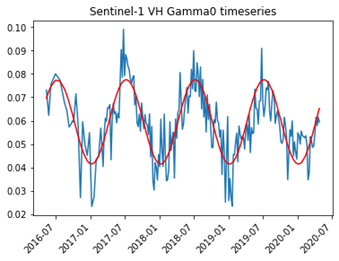

## Curve fitting

In [ ]:
def fitFunction(x:ProcessBuilder, parameters:ProcessBuilder):
    t = 2 * math.pi / 31557600 * x
    return parameters[0] + parameters[1] * cos(t) + parameters[2] * sin(t)

curve_fitting = l2a_bands_clipped.fit_curve(
    parameters=[1,1,1], # Initial guess of the parameters
    dimension="t",      # Fit the function along the temporal dimension
    function=fitFunction
)

Save the result parameters as a netCDF for later use and start the batch job

In [ ]:
fitted_parameters = curve_fitting.save_result(format="NetCDF")

In [ ]:
job = fitted_parameters.send_job(title = "S2_curve_fitting_SRR2")
jobIdFitting = job.job_id
job.start_job()

### Check the fitting job status and when it is marked as 'finished', you can continue

In [ ]:
conn.job(jobIdFitting)

## Curve prediction and change detection threshold

Given the computed parameters stored in a netCDF from the previous job, we can now reuse them, predicting the values in the training period when following the sinuisoidal behavior.

With the difference between predicted and real data, we compute the RMSE over the training period and finally the standard deviation over time, resulting in a final raster with a single band and no time dimension.

Load result parameters from previous job

In [ ]:
curve_fitting_loaded = conn.load_result(id=jobIdFitting)

Compute the predicted values

In [ ]:
temporal_labels = l2a_bands_clipped.dimension_labels('t')
curve_prediction = l2a_bands_clipped.predict_curve(parameters=curve_fitting_loaded,dimension='t',function=fitFunction,labels=temporal_labels)

Mask out the cloud covered areas as in the original training data

Create a cloud mask based on the cloud masked areas produced by FORCE

In [ ]:
force_cloud_mask = l2a_bands.apply(lambda x: x.gt(0))

In [ ]:
predicted_masked = curve_prediction.merge_cubes(force_cloud_mask,overlap_resolver=multiply)

Subtract the predicted values from the pre-processed S-2 data

In [ ]:
merged_cubes = l2a_bands_clipped.merge_cubes(predicted_masked,overlap_resolver=subtract)

Compute the RMSE

In [ ]:
from change_detection_utils import compute_residual
bands           = ["B02","B03","B04","B05","B08"]
rmse = compute_residual(merged_cubes,bands)

Compute the standard deviation of the residual error over time

In [ ]:
rmse_std = rmse.reduce_dimension(dimension='t',reducer=sd)

Save the resulting layer as netCDF and start the batch job

In [ ]:
rmse_std_netcdf = rmse_std.save_result(format="NetCDF")

In [ ]:
job = rmse_std_netcdf.send_job(title = "S2_curve_predicting_SRR2")
jobIdPredicting = job.job_id
job.start_job()

### Sample result from the curve fitting and prediction steps
The following plot shows a pixel time series from the infrared band. In blue the raw signal and in orange the fitted seasonal trend
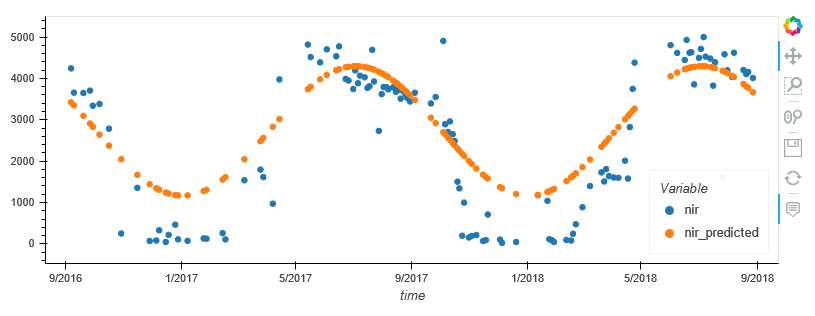

### Check the predicting job status and when it is marked as 'finished', you can continue

In [ ]:
conn.job(jobIdPredicting)

In [ ]:
# jobIdPredicting = ""
# jobIdFitting    = ""

# Change detection

Given the fitted function to each pixel, we can find out how much the signal deviates from the model and flag it as a change when it goes beyond a threshold.

The following example shows how noticeable is the change in the SAR (Sentinel-1) signal after the Vaia storm of a forest area affected from it.

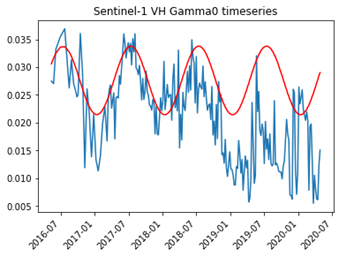

TIP: If you want to use the same bbox as a previously executed job, you can use the following function to retrieve the spatial extent, using the corresponding job id:

In [ ]:
from change_detection_utils import get_bbox_from_job
job = conn.job(jobIdFitting)
spatial_extent = get_bbox_from_job(job)
print(spatial_extent)

Load the precomputed parameters

In [ ]:
curve_fitting_loaded = conn.load_result(id=jobIdFitting)

Load the testing data and filter it in the same way as we did for training

In [ ]:
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ["2018-10-01", "2019-03-01"] # This is the testing period

collection      = 'boa_sentinel_2'
bands           = ["B02","B03","B04","B05","B08"]

l2a_bands_test = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

Clip the data to avoid unmasked clouds

In [ ]:
l2a_bands_test_clipped = l2a_bands_test.apply(lambda x: x.clip(0,5000))

## Curve prediction
Predict the values that the test data should have following the seasonal trend

In [ ]:
temporal_labels_test = l2a_bands_test_clipped.dimension_labels('t')
curve_prediction_test = l2a_bands_test_clipped.predict_curve(parameters=curve_fitting_loaded,dimension='t',function=fitFunction,labels=temporal_labels_test)

Create a cloud mask based on the cloud masked areas produced by FORCE

In [ ]:
force_cloud_mask_test = l2a_bands_test.apply(lambda x: x.gt(0))

In [ ]:
predicted_masked_test = curve_prediction_test.merge_cubes(force_cloud_mask_test,overlap_resolver=multiply)

In [ ]:
merged_cubes_test = l2a_bands_test_clipped.merge_cubes(predicted_masked_test,overlap_resolver=subtract)

Compute the residual error for each time step in the testing period

In [ ]:
from change_detection_utils import compute_residual
bands           = ["B02","B03","B04","B05","B08"]
residual        = compute_residual(merged_cubes,bands)

### Set the thresold for the change detection
We raise and alarm if residual error > 3*std

It is not mandatory to use 3 as multiplicative factor, it depends on the signal and how big are deviations from the model that we want to detect.

Load precomputed threshold layer

In [ ]:
training_std_loaded = conn.load_result(id=jobIdPredicting)

In [ ]:
alarm_threshhold = training_std_loaded.apply(lambda x: x * 3)

In [ ]:
alarm_cubes = residual.merge_cubes(alarm_threshhold,overlap_resolver=gt)

Save the resulting timeseries of change alarms as netCDF and start the batch job

In [ ]:
alarm_cubes_netcdf = alarm_cubes.save_result(format="NetCDF")

In [ ]:
job = alarm_cubes_netcdf.send_job(title = "S2_change_detection_SRR2")
jobIdAlarms = job.job_id
job.start_job()

In [ ]:
#jobIdAlarms = "jb-3131a9f0-7caf-464d-befd-d52359c79839"

Check the change detection job status and when it is marked as 'finished', you can continue

In [ ]:
conn.job(jobIdAlarms)

Download the results. Please note: each time step will be downloaded as a separate file

In [ ]:
jobAlarms = conn.job(jobIdAlarms)
jobResults = jobAlarms.get_results()
jobResults.download_files('./results')

# Visualization of detected changes

We consider and visualize a detected change only if there are 3 subsequent changes detected. You can modify the value of subsequentAlarms with a bigger or smaller amount and see what changes.

If monthlyAggregate=True, we compute the aggregation of the detected changes for each month. If your testing period covers more than 12 months, the aggregation will be performed over all the data for the month (Jan,Feb,...), independently from which year.

In [ ]:
from change_detection_utils import plot_detected_changes
plot_detected_changes(netcdfPath='./results/out_*.nc',monthlyAggregate=False,subsequentAlarms=3,backgroundTiles='OSM') #Try 'ESRI' as backgroundTiles for satellite RGB background